# Titanic: Machine Learning from Disaster
Predict survival on the Titanic
https://www.kaggle.com/c/titanic

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [33]:
from fastai import *
from fastai.tabular import *
from fastai.metrics import error_rate
import pandas as pd

In [3]:
path = Config.data_path()/'titanic'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/storage/titanic')

In [4]:
! kaggle competitions download -c titanic -p {path} 

  0%|                                               | 0.00/59.8k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 59.8k/59.8k [00:00<00:00, 2.36MB/s]
  0%|                                               | 0.00/28.0k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 28.0k/28.0k [00:00<00:00, 1.33MB/s]
  0%|                                               | 0.00/3.18k [00:00<?, ?B/s]
100%|███████████████████████████████████████| 3.18k/3.18k [00:00<00:00, 239kB/s]


In [5]:
! ls {path}

gender_submission.csv  test.csv  train.csv


In [6]:
train_csv_pd = pd.read_csv(path/'train.csv'); train_csv_pd.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [49]:
test_csv_pd = pd.read_csv(path/'test.csv'); test_csv_pd.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Some feature ingeneering - try to use name - there are some Mrs Mr - can help

In [18]:
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    return np.nan

In [19]:
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']

In [20]:
train_csv_pd['Title']=train_csv_pd['Name'].map(lambda x: substrings_in_string(x, title_list))

In [50]:
test_csv_pd['Title']=test_csv_pd['Name'].map(lambda x: substrings_in_string(x, title_list))

In [21]:
train_csv_pd.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [22]:
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [24]:
train_csv_pd['Title']=train_csv_pd.apply(replace_titles, axis=1); train_csv_pd.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [51]:
test_csv_pd['Title']=test_csv_pd.apply(replace_titles, axis=1)

In [28]:
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
train_csv_pd['Deck']=train_csv_pd['Cabin'].map(lambda x: substrings_in_string(str(x), cabin_list));train_csv_pd.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,NaN


In [52]:
test_csv_pd['Deck']=test_csv_pd['Cabin'].map(lambda x: substrings_in_string(str(x), cabin_list))

In [30]:
train_csv_pd['Family_Size']=train_csv_pd['SibSp']+train_csv_pd['Parch']; train_csv_pd.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,Family_Size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,NaN,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,NaN,0


In [53]:
test_csv_pd['Family_Size']=test_csv_pd['SibSp']+test_csv_pd['Parch']

In [31]:
train_csv_pd['Fare_Per_Person']=train_csv_pd['Fare']/(train_csv_pd['Family_Size']+1);train_csv_pd.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,Family_Size,Fare_Per_Person
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,NaN,1,3.62500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,1,35.64165
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,NaN,0,7.92500
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,1,26.55000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,NaN,0,8.05000


In [57]:
test_csv_pd['Fare_Per_Person']=test_csv_pd['Fare']/(test_csv_pd['Family_Size']+1);

In [61]:
test_csv_pd.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,Family_Size,Fare_Per_Person
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,NaN,0,7.829200
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,NaN,1,3.500000
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,NaN,0,9.687500
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,NaN,0,8.662500
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,NaN,2,4.095833


In [62]:
dep_var = 'Survived'
cat_names = ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck']
cont_names = ['Age', 'Family_Size']
procs = [FillMissing, Categorify, Normalize]

In [63]:
test = TabularList.from_df(test_csv_pd, path=path, cat_names=cat_names,
                                 cont_names=cont_names)

In [64]:
data = (TabularList.from_df(train_csv_pd, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(700,800)))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [65]:
data.show_batch(rows=10)

Pclass,Sex,Embarked,Title,Deck,Age_na,Age,Family_Size,target
3,male,S,Mr,#na#,False,-0.3402,0.0434,0
3,female,S,Miss,#na#,False,-0.2639,-0.5694,1
3,male,C,Mr,#na#,False,-0.5691,-0.5694,0
3,male,S,Mr,#na#,False,-0.1113,0.6561,0
3,male,S,Mr,#na#,False,0.5752,0.6561,0
3,female,S,Miss,#na#,False,1.1856,-0.5694,0
3,female,Q,Miss,#na#,False,-1.0268,-0.5694,1
1,female,S,Miss,B,False,-1.1031,0.0434,1
3,female,S,Miss,#na#,False,-0.1113,-0.5694,0
1,female,C,Miss,E,False,0.0412,-0.5694,1


## Training

In [66]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


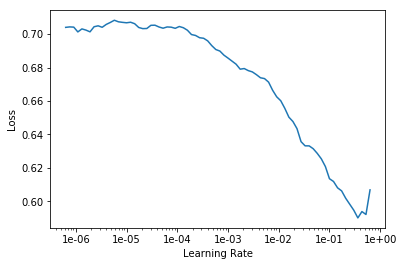

In [67]:
learn.lr_find()
learn.recorder.plot()

In [71]:
learn.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.332725,0.296205,0.880000,00:01
1,0.327550,0.296164,0.870000,00:00
2,0.330647,0.293182,0.860000,00:00
3,0.330498,0.292981,0.870000,00:00
4,0.329338,0.293802,0.860000,00:00
5,0.330353,0.289796,0.870000,00:00
6,0.326712,0.289365,0.870000,00:00
7,0.328596,0.281652,0.880000,00:00
8,0.330004,0.289412,0.880000,00:00
9,0.333088,0.289868,0.880000,00:00


## Submitting results to kaggle

In [73]:
len(learn.data.test_ds)

418

In [80]:
row = test_csv_pd.iloc[0]

In [89]:
learn.export()

In [90]:
test = TabularList.from_df(test_csv_pd, path=path, cat_names=cat_names,
                                 cont_names=cont_names)

In [91]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [92]:
data_classes = [learn.data.classes[pred.argmax().item()] for pred in preds]

In [94]:
data_classes[1]

0

In [74]:
submission = pd.DataFrame(columns=['PassengerId', 'Survived']); submission.head()

,PassengerId,Survived


In [96]:
submission['PassengerId'] = test_csv_pd['PassengerId']; submission.head()

,PassengerId,Survived
0,892,NaN
1,893,NaN
2,894,NaN
3,895,NaN
4,896,NaN


In [97]:
submission['Survived'] = data_classes; submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [98]:
submission.to_csv(path/'submission04262019.csv', index=False)

In [99]:
! kaggle competitions submit titanic -f {path/'submission04262019.csv'} -m "My submission"

100%|██████████████████████████████████████| 2.77k/2.77k [00:00<00:00, 4.47kB/s]
Successfully submitted to Titanic: Machine Learning from Disaster